# Tephra Inversion Framework Demo

This notebook demonstrates the streamlined tephra inversion workflow for estimating plume height and eruption mass using Tephra2.

In [ ]:
# Cell 1: Import necessary modules
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Ensure project root is in the path
project_root = Path.cwd()
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

# Import the TephraInversion class
from scripts.tephra_inversion import TephraInversion

# Set up matplotlib
plt.style.use("seaborn-v0_8")
%matplotlib inline
!tree -L 3

.
├── README.md
├── config
│   ├── __pycache__
│   │   └── default_config.cpython-311.pyc
│   └── default_config.py
├── data
│   ├── input
│   │   ├── observations.csv
│   │   ├── sites.csv
│   │   └── wind.txt
│   └── output
│       ├── mcmc
│       └── plots
├── demo.ipynb
├── requirements.txt
├── scripts
│   ├── __pycache__
│   │   └── tephra_inversion.cpython-311.pyc
│   ├── core
│   │   ├── __pycache__
│   │   ├── lhs.py
│   │   ├── mcmc.py
│   │   └── tephra2_interface.py
│   ├── data_handling
│   │   ├── __pycache__
│   │   ├── coordinate_utils.py
│   │   ├── esp_config.py
│   │   ├── observation_data.py
│   │   └── wind_data.py
│   ├── tephra_inversion.py
│   └── visualization
│       ├── __pycache__
│       ├── diagnostic_plots.py
│       ├── observation_plots.py
│       └── wind_plots.py
├── tephra2
│   └── tephra2_2020
└── tinvvenv
    ├── bin
    │   ├── Activate.ps1
    │   ├── activate
    │   ├── activate.csh
    │   ├── activate.fish
    │   ├── black
    │   ├── blackd

## Initialize the Inversion Framework
 
First, we create an instance of the TephraInversion class, which sets up all necessary directories and initializes handlers for wind data, observation data, and the Tephra2 interface.


In [ ]:
# Cell 2: Initialize the inversion framework
inversion = TephraInversion()

# Create input and output directories if they don't exist
for dir_path in ["data/input", "data/output/plots", "data/output/mcmc"]:
    Path(dir_path).mkdir(parents=True, exist_ok=True)

print("Input directory:", Path("data/input").absolute())
print("Output directory:", Path("data/output").absolute())

# %%
# Check for existing data files
input_dir = Path("data/input")
obs_file = input_dir / "observations.csv"
sites_file = input_dir / "sites.csv"
wind_file = input_dir / "wind.txt"

print("Checking for existing data files:")
print(f"Observations file exists: {obs_file.exists()}")
print(f"Sites file exists: {sites_file.exists()}")
print(f"Wind file exists: {wind_file.exists()}")

## Set Vent Location
 
We start by setting the vent location using latitude and longitude coordinates. The framework automatically converts these to UTM coordinates.

In [3]:
# Cell 3: Set vent location
# Example: Kirishima volcano, Japan
vent_lat = 31.93
vent_lon = 130.93
vent_elev = 1000  # meters above sea level

inversion.setup_vent_location(vent_lat, vent_lon, vent_elev)

Vent location set: 31.93°N, 130.93°E, 1000m elevation
UTM coordinates: Easting 682452.5m, Northing 3534302.4m


## Set Eruption Time
 
Next, we set the eruption time. This is used for documentation and potentially for fetching wind data from reanalysis sources.

In [4]:
# Cell 4: Set eruption time
eruption_time = ["2011", "01", "26", "15:00"]  # YYYY, MM, DD, HH:MM
inversion.setup_eruption_time(eruption_time)

Eruption time set: 2011-01-26 15:00


## Set Up Wind Data
 
Now we set up the wind profile. We can either load existing wind data or generate synthetic wind data.

Wind data saved to: data/input/data/input/wind.txt
Synthetic wind data saved to: data/input/data/input/wind.txt


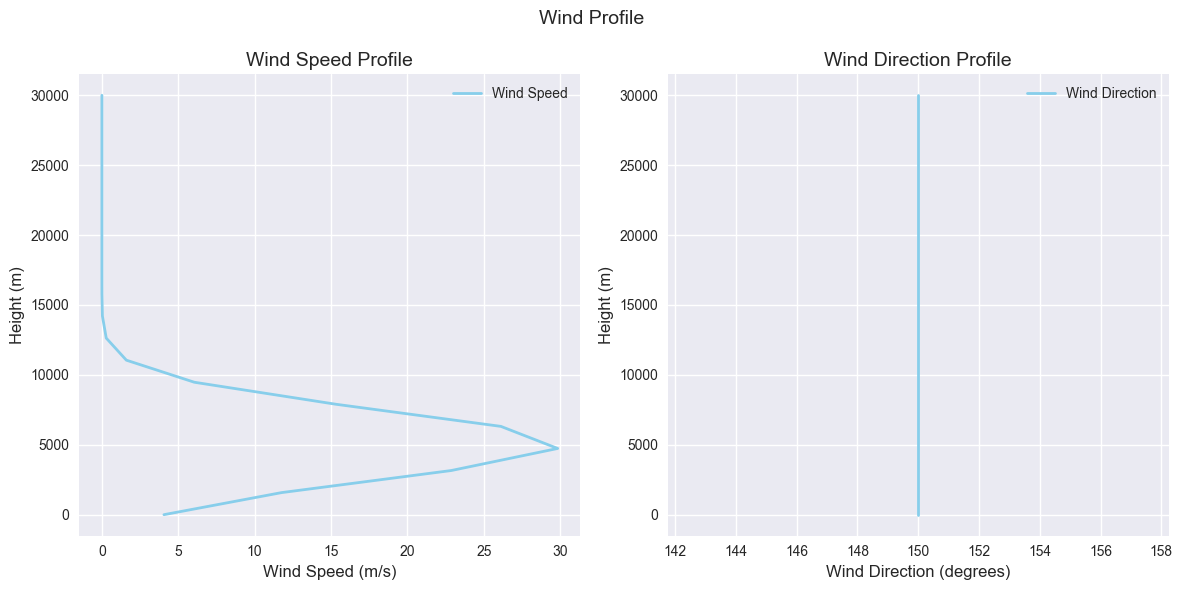

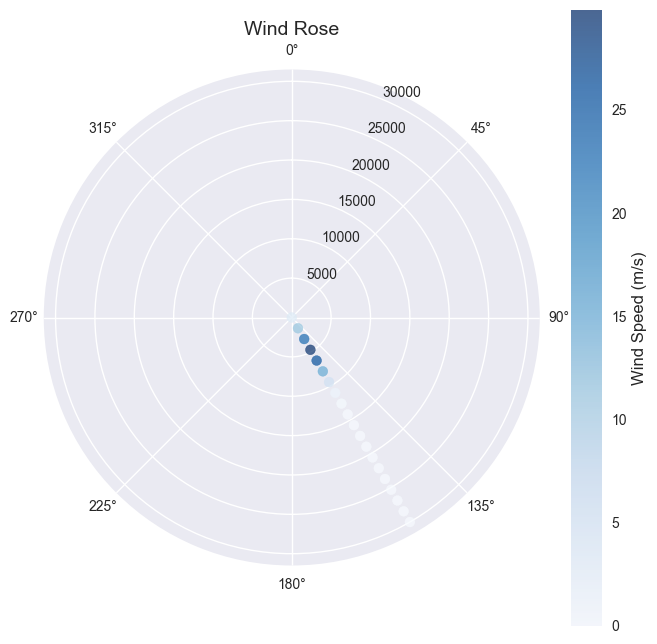

Wind visualizations saved to:
data/output/plots/wind_profile.png
data/output/plots/wind_rose.png


In [5]:
# Cell 5: Set up wind data
# This will automatically check for existing wind.txt in the input directory
# If not found, it will try API, then fall back to synthetic data
inversion.setup_wind_data(ask_user=False)  # Don't prompt user in notebook

# Show the first few rows of the wind data
if inversion.wind_data is not None:
    print("\nWind data summary:")
    print(inversion.wind_data.head())

## Set Up Observation Data
 
Next, we set up the observation data. We can either load existing data or generate synthetic data.

Observations saved to: data/input/observations.csv
Sites saved to: data/input/sites.csv


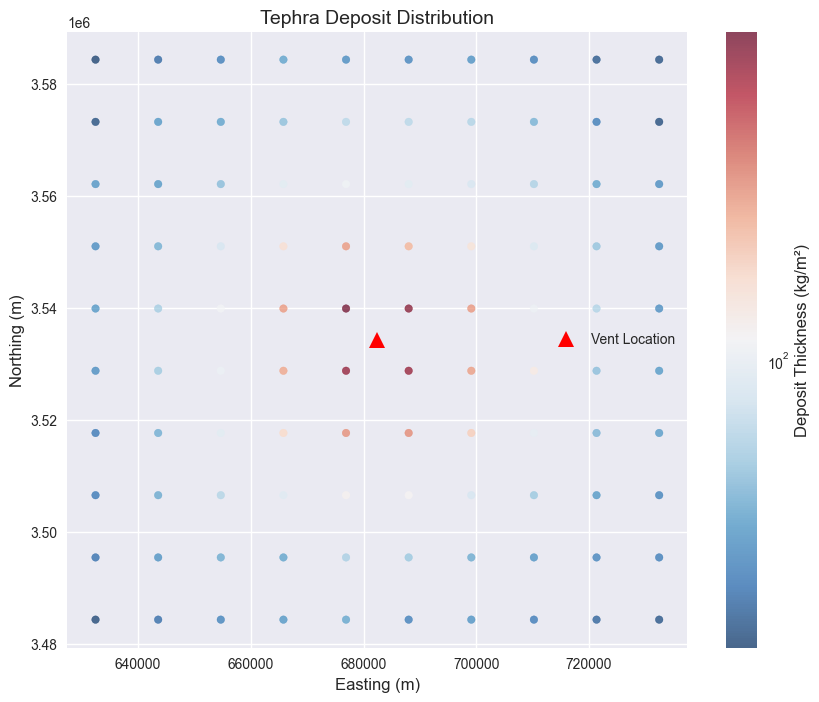

Tephra distribution plot saved to: data/output/plots/tephra_distribution.png


In [6]:
# Cell 6: Set up observation data
# This will automatically check for existing observations.csv and sites.csv
# If not found, it will generate synthetic data
inversion.setup_observation_data(ask_user=False)  # Don't prompt user in notebook

# Show a summary of the observation data
if inversion.observations is not None and inversion.sites is not None:
    print("\nObservation data summary:")
    print(f"Number of observations: {len(inversion.observations)}")
    print(f"Min loading: {inversion.observations.min():.2f} kg/m²")
    print(f"Max loading: {inversion.observations.max():.2f} kg/m²")
    print(f"Observation sites shape: {inversion.sites.shape}")

## Set Up Parameters
 
Now we set up the parameters for the inversion.

In [7]:
# Cell 7: Set up parameters
mcmc_params = inversion.setup_parameters()

print("MCMC Parameters:")
print(f"Initial values: plume_height={mcmc_params['initial_values'][0]} m, log_mass={mcmc_params['initial_values'][1]}")
print(f"Prior types: {mcmc_params['prior_type']}")
print(f"Prior parameters (min, max):")
print(f"  Plume height: {mcmc_params['prior_parameters'][0][0]}-{mcmc_params['prior_parameters'][0][1]} m")
print(f"  Log mass: {mcmc_params['prior_parameters'][1][0]}-{mcmc_params['prior_parameters'][1][1]}")
print(f"Draw scales: {mcmc_params['draw_scale']}")

Parameter configuration file created at: data/input/tephra2.conf
MCMC Parameters:
Initial values: plume_height=10000.0 m, log_mass=22.0
Prior types: ['Uniform' 'Uniform']
Prior parameters (min, max):
  Plume height: 5000-20000 m
  Log mass: 20-25
Draw scales: [500.    0.5]


## Run MCMC Inversion
 
Now we run the MCMC inversion to estimate the plume height and eruption mass.

In [8]:
# Cell 8: Run MCMC inversion
# For testing, we can use a smaller number of iterations
inversion.config["mcmc"]["n_iterations"] = 1000  # Reduced for demonstration
inversion.config["mcmc"]["n_burnin"] = 200

results = inversion.run_inversion()

2025-04-27 23:40:34,986 - scripts.core.mcmc - ERROR - Unexpected error in run_tephra2: [Errno 13] Permission denied: 'tephra2/tephra2_2020'
2025-04-27 23:40:34,987 - scripts.core.mcmc - ERROR - Fatal error in MCMC: [Errno 13] Permission denied: 'tephra2/tephra2_2020'


Parameter configuration file created at: data/input/tephra2.conf

Running MCMC parameter estimation...


PermissionError: [Errno 13] Permission denied: 'tephra2/tephra2_2020'

## Analyze Results

Now we analyze the results of the inversion.

In [ ]:
# Cell 9: Plot results
burnin = inversion.config["mcmc"]["n_burnin"]

# Plot plume height trace
plt.figure(figsize=(10, 6))
plt.plot(results["chain"]["plume_height"][burnin:], alpha=0.7)
plt.axhline(results["best_params"]["plume_height"], color='r', linestyle='--', 
            label=f'Best: {results["best_params"]["plume_height"]:.1f} m')
plt.xlabel('Iteration (after burn-in)')
plt.ylabel('Plume Height (m)')
plt.title('MCMC Chain for Plume Height')
plt.legend()
plt.grid(True)
plt.show()

# Plot eruption mass histogram
plt.figure(figsize=(10, 6))
mass_values = 10 ** results["chain"]["log_m"][burnin:]
best_mass = 10 ** results["best_params"]["log_m"]
plt.hist(mass_values, bins=30, alpha=0.7)
plt.axvline(best_mass, color='r', linestyle='--', label=f'Best: {best_mass:.2e} kg')
plt.xlabel('Eruption Mass (kg)')
plt.ylabel('Frequency')
plt.title('Posterior Distribution of Eruption Mass')
plt.xscale('log')
plt.legend()
plt.grid(True)
plt.show()

# Plot joint posterior
plt.figure(figsize=(10, 8))
plt.scatter(
    results["chain"]["plume_height"][burnin:],
    results["chain"]["log_m"][burnin:],
    alpha=0.3,
    s=10
)
plt.scatter(
    results["best_params"]["plume_height"],
    results["best_params"]["log_m"],
    color='red',
    s=100,
    marker='*',
    label=f'Best Fit: {results["best_params"]["plume_height"]:.1f} m, 10^{results["best_params"]["log_m"]:.2f} kg'
)
plt.xlabel('Plume Height (m)')
plt.ylabel('Log10 Eruption Mass (kg)')
plt.title('Joint Posterior Distribution')
plt.legend()
plt.grid(True)
plt.show()

## Summary

We have successfully performed tephra inversion to estimate plume height and eruption mass for a volcanic eruption. The best-fit parameters are:

- Plume height: {best_plume_height:.1f} meters
- Eruption mass: {best_mass:.2e} kg

These parameters can be used to simulate the tephra dispersion and compare with observations.

In [ ]:
# Cell 10: Plot comparison of observed vs predicted
# Calculate residuals
best_plume_height = results["best_params"]["plume_height"]
best_log_mass = results["best_params"]["log_m"]
best_mass = 10 ** best_log_mass

residuals = np.log10(inversion.observations) - np.log10(results["predictions"])
rmse = np.sqrt(np.mean(residuals**2))

plt.figure(figsize=(10, 8))
plt.scatter(inversion.observations, results["predictions"], alpha=0.7)
plt.plot([inversion.observations.min(), inversion.observations.max()], 
         [inversion.observations.min(), inversion.observations.max()], 
         'r--', alpha=0.7)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Observed Mass Loading (kg/m²)')
plt.ylabel('Predicted Mass Loading (kg/m²)')
plt.title(f'Observed vs Predicted Mass Loading\nRMSE (log10): {rmse:.4f}')
plt.grid(True)
plt.show()

In [ ]:
# Cell 11: Print final summary
print("Final Inversion Results:")
print(f"Plume Height: {best_plume_height:.1f} m")
print(f"Eruption Mass: {best_mass:.2e} kg")
print(f"Acceptance Rate: {results['acceptance_rate']:.2f}")
print(f"RMSE (log10): {rmse:.4f}")
print(f"Results file: {results.get('results_file', 'Not saved')}")

## Run Complete Workflow (Interactive)
Alternatively, you can run the complete workflow with interactive prompts:

In [ ]:
# Cell 12: Run interactive workflow (uncomment to run)
# new_inversion = TephraInversion()
# new_results = new_inversion.run_workflow()